In [2]:
import sqlite3
import pandas as pd
from IPython.display import display

In [2]:
!cp ../Scrapers/nfl.db .
!cp -r ../Scrapers/data .

To dive deeper into analysis using the betting lines and the full game data in your dataset, here are several avenues you can explore for both fantasy football and sports betting insights:

### 1. **Betting Line Analysis:**
   - **Spread Line Performance:** Analyze how well teams perform against the spread. This involves calculating the difference between the actual game margin and the spread to see which teams consistently beat or fall short of the spread.
   - **Home vs. Away Performance:** Examine how teams perform at home versus on the road, especially in relation to the betting lines. Some teams may perform better or worse than expected depending on the venue.
   - **Over/Under Analysis:** Study the total lines (over/under) to see how often games go over or under the projected total points. Identify teams or matchups that frequently result in high-scoring or low-scoring games.

### 2. **Fantasy Football Insights:**
   - **Player Performance vs. Betting Lines:** Correlate player performances, such as fantasy points, with the spread and total lines. For example, do star players perform better in games with high total lines? How do quarterbacks fare in games where their team is heavily favored?
   - **Impact of Game Scripts:** Use the spread and total lines to predict game scripts (e.g., a team expected to win by a large margin might rely more on the run game in the second half). This can inform decisions on which players to start or sit.
   - **Matchup Analysis:** Dive into defensive and offensive matchups using the data. For example, you can look at how certain defenses perform against specific positions (like WRs or RBs) and cross-reference this with upcoming games' betting lines.

### 3. **Trend Analysis:**
   - **Seasonal Trends:** Examine how certain teams or players perform at different points in the season. Some teams may start strong but fade, while others may improve as the season progresses.
   - **Head-to-Head Matchups:** Analyze historical head-to-head matchups to see if certain teams or coaches consistently outperform expectations against specific opponents.
   - **Player Consistency:** Track player consistency across games and seasons, especially in high-pressure situations or important matchups (e.g., divisional games, playoffs).

### 4. **Advanced Metrics:**
   - **Elo Ratings:** Implement Elo ratings to rank teams and predict outcomes more accurately. Elo can also be used to simulate the rest of the season and predict playoff probabilities.
   - **Expected Points Added (EPA):** Calculate or use existing metrics like EPA to evaluate player and team efficiency. Compare these metrics against the betting lines to identify value opportunities.

### 5. **Machine Learning Models:**
   - **Predictive Models:** Use machine learning to predict game outcomes, player performances, or even fantasy points based on historical data, betting lines, and other features. 
   - **Clustering:** Group games or players into clusters based on performance metrics, betting lines, or other criteria. This can reveal patterns that might not be obvious at first glance.

### 6. **Value Betting Opportunities:**
   - **Line Movements:** Track how betting lines move leading up to a game. Significant movements can indicate where the smart money is going, and comparing these movements with your analysis can uncover value bets.
   - **Underdog Performance:** Identify situations where underdogs consistently outperform expectations, either outright or against the spread.

### Next Steps:
- Start by running some exploratory analysis on the spread and total lines in your dataset.
- Develop models or analysis scripts that focus on the areas above, depending on whether your primary interest is fantasy football, sports betting, or both.

If you want help with specific analyses or need assistance setting up models or scripts, feel free to ask!

In [3]:
db_path = 'nfl.db'  # Update this path if needed

conn = sqlite3.connect(db_path)

# Get all table names
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = conn.execute(tables_query).fetchall()

# Download each table to a CSV file
for table in tables:
    table_name = table[0]
    # Read the table into a pandas DataFrame
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    # Save the DataFrame to a CSV file
    csv_file_name = f"{table_name}.csv"
    df.to_csv(csv_file_name, index=False)
    print(f"Downloaded {table_name} to {csv_file_name}")

# Close the connection
conn.close()

Downloaded Teams to Teams.csv
Downloaded Games to Games.csv
Downloaded PlayerStats to PlayerStats.csv
Downloaded Rosters to Rosters.csv


In [4]:
# --- Creating home_spread and away_spread columns in nfl.db --- #

df = pd.read_csv('Games.csv')

# Remove rows where the 'season' column has the value 2024
df = df[df['season'] != 2024]

# Calculate home_spread and away_spread directly
df['home_spread'] = df['spread_line'].apply(lambda x: f"+{x}" if x > 0 else f"{x}")
df['away_spread'] = df['spread_line'].apply(lambda x: f"-{x}" if x > 0 else f"+{-x}")

# Save the updated DataFrame to a new CSV file
df.to_csv('Games.csv', index=False)

print("Columns 'home_spread' and 'away_spread' have been added and updated for all rows in the 'Games.csv' file.")

Columns 'home_spread' and 'away_spread' have been added and updated for all rows in the 'Games.csv' file.


In [5]:
# Teams ATS Records
# Print Last Season's For Every Team

# Function to determine the ATS result for a game using actual scores and spread
def ats_result(row, team):
    try:
        spread = float(row['home_spread']) if row['home_team'] == team else float(row['away_spread'])
        score_diff = row['home_score'] - row['away_score'] if row['home_team'] == team else row['away_score'] - row['home_score']
        if score_diff > spread:
            return 'Win'
        elif score_diff < spread:
            return 'Loss'
        else:
            return 'Push'
    except ValueError:
        return 'Invalid'

# Load the CSV file
csv_path = 'Games.csv'  # Adjust the path to your CSV file
games_df = pd.read_csv(csv_path)

# Convert relevant columns to numeric, handling errors
games_df['home_spread'] = pd.to_numeric(games_df['home_spread'], errors='coerce')
games_df['away_spread'] = pd.to_numeric(games_df['away_spread'], errors='coerce')

# List of all NFL teams
teams = ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 
         'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 
         'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

# Specify the season year
season_year = 2023

# Loop through each team to calculate ATS records
for team in teams:
    relevant_columns = ['home_team', 'away_team', 'home_score', 'away_score', 'home_spread', 'away_spread', 'season']
    # Filter for the current season and team
    team_games = games_df[(games_df['home_team'] == team) | (games_df['away_team'] == team)]
    team_games = team_games[team_games['season'] == season_year]
    team_games = team_games[relevant_columns]
    
    # Calculate ATS result
    team_games['ATS_Result'] = team_games.apply(lambda row: ats_result(row, team), axis=1)

    overall_ats_record = team_games['ATS_Result'].value_counts()
    home_ats_record = team_games[team_games['home_team'] == team]['ATS_Result'].value_counts()
    away_ats_record = team_games[team_games['away_team'] == team]['ATS_Result'].value_counts()

    # Display the results for each team
    # print(f"{team} ATS Record for {season_year} Season:")
    # print("Overall:", overall_ats_record)
    # print("Home:", home_ats_record)
    # print("Away:", away_ats_record)
    # print("\n")  # Add a newline for better readability
    print(f"\n{team} ATS Record for {season_year} Season:")
    
    # Print DataFrames without row indexes and column headers directly in the print lines
    print("\nOverall:")
    print(pd.DataFrame(overall_ats_record).reset_index().rename(columns={'index': 'ATS_Result', 'ATS_Result': 'Count'})
          .to_string(index=False, header=False))
    
    print("\nHome:")
    print(pd.DataFrame(home_ats_record).reset_index().rename(columns={'index': 'ATS_Result', 'ATS_Result': 'Count'})
          .to_string(index=False, header=False))
    
    print("\nAway:")
    print(pd.DataFrame(away_ats_record).reset_index().rename(columns={'index': 'ATS_Result', 'ATS_Result': 'Count'})
          .to_string(index=False, header=False))
    print("-"*100)


ARI ATS Record for 2023 Season:

Overall:
 Win 9
Loss 8

Home:
 Win 5
Loss 3

Away:
Loss 5
 Win 4
----------------------------------------------------------------------------------------------------

ATL ATS Record for 2023 Season:

Overall:
Loss 12
 Win  5

Home:
Loss 5
 Win 3

Away:
Loss 7
 Win 2
----------------------------------------------------------------------------------------------------

BAL ATS Record for 2023 Season:

Overall:
 Win 12
Loss  7

Home:
 Win 6
Loss 5

Away:
 Win 6
Loss 2
----------------------------------------------------------------------------------------------------

BUF ATS Record for 2023 Season:

Overall:
Loss 11
 Win  8

Home:
Loss 6
 Win 5

Away:
Loss 5
 Win 3
----------------------------------------------------------------------------------------------------

CAR ATS Record for 2023 Season:

Overall:
Loss 11
 Win  4
Push  2

Home:
Loss 4
 Win 3
Push 1

Away:
Loss 7
Push 1
 Win 1
-----------------------------------------------------------------------

In [3]:
# Teams ATS Records
# Loop & Save All Seasons

# Function to determine the ATS result for a game using actual scores and spread
def ats_result(row, team):
    try:
        spread = float(row['home_spread']) if row['home_team'] == team else float(row['away_spread'])
        score_diff = row['home_score'] - row['away_score'] if row['home_team'] == team else row['away_score'] - row['home_score']
        if score_diff > spread:
            return 'Win'
        elif score_diff < spread:
            return 'Loss'
        else:
            return 'Push'
    except ValueError:
        return 'Invalid'

# Load the CSV file
csv_path = 'Games.csv'  # Adjust the path to your CSV file
games_df = pd.read_csv(csv_path)

# Convert relevant columns to numeric, handling errors
games_df['home_spread'] = pd.to_numeric(games_df['home_spread'], errors='coerce')
games_df['away_spread'] = pd.to_numeric(games_df['away_spread'], errors='coerce')

# List of all NFL teams
teams = ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 
         'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 
         'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

# Create a list to collect the results for saving
results = []

# Loop through each season year available in the data
for season_year in games_df['season'].unique():
    for team in teams:
        relevant_columns = ['home_team', 'away_team', 'home_score', 'away_score', 'home_spread', 'away_spread', 'season']
        # Filter for the current season and team
        team_games = games_df[(games_df['home_team'] == team) | (games_df['away_team'] == team)]
        team_games = team_games[team_games['season'] == season_year]
        team_games = team_games[relevant_columns]
        
        # Calculate ATS result
        team_games['ATS_Result'] = team_games.apply(lambda row: ats_result(row, team), axis=1)

        overall_ats_record = team_games['ATS_Result'].value_counts().reset_index()
        overall_ats_record.columns = ['ATS_Result', 'Count']
        overall_ats_record['Location'] = 'Overall'
        overall_ats_record['Team'] = team
        overall_ats_record['Season'] = season_year

        home_ats_record = team_games[team_games['home_team'] == team]['ATS_Result'].value_counts().reset_index()
        home_ats_record.columns = ['ATS_Result', 'Count']
        home_ats_record['Location'] = 'Home'
        home_ats_record['Team'] = team
        home_ats_record['Season'] = season_year

        away_ats_record = team_games[team_games['away_team'] == team]['ATS_Result'].value_counts().reset_index()
        away_ats_record.columns = ['ATS_Result', 'Count']
        away_ats_record['Location'] = 'Away'
        away_ats_record['Team'] = team
        away_ats_record['Season'] = season_year

        # Append results to the list
        results.append(overall_ats_record)
        results.append(home_ats_record)
        results.append(away_ats_record)

# Combine all results into a single DataFrame
final_df = pd.concat(results)

# Save the results to a CSV file
output_csv_path = 'ATS_Records.csv'
final_df.to_csv(output_csv_path, index=False)

print(f"ATS records have been saved to {output_csv_path}")
!open ATS_Records.csv

FileNotFoundError: [Errno 2] No such file or directory: 'Games.csv'

In [7]:
# Betting Line Analysis:

df = pd.read_csv('Games.csv')

# Filter for the specific seasons (e.g., last 5 seasons: 2019, 2020, 2021, 2022, 2023)
df_recent = df[df['season'].isin([2019, 2020, 2021, 2022, 2023])].copy()

# 1. Spread Line Performance: Calculate the difference between the actual game margin and the spread.
df_recent.loc[:, 'game_margin'] = df_recent['home_score'] - df_recent['away_score']
df_recent.loc[:, 'spread_performance'] = df_recent['game_margin'] - df_recent['spread_line']

# Analyze which teams consistently beat or fall short of the spread
spread_performance_summary = df_recent.groupby('home_team')['spread_performance'].mean().sort_values(ascending=False)

# 2. Home vs. Away Performance: Calculate the performance difference at home versus away
home_performance = df_recent.groupby('home_team')['spread_performance'].mean()
away_performance = df_recent.groupby('away_team')['spread_performance'].mean()
home_vs_away_performance = (home_performance - away_performance).sort_values(ascending=False)

# 3. Over/Under Analysis: Calculate the difference between total points and total_line
df_recent.loc[:, 'total_points'] = df_recent['home_score'] + df_recent['away_score']
df_recent.loc[:, 'over_under_performance'] = df_recent['total_points'] - df_recent['total_line']

# Analyze how often games go over or under the projected total points
over_under_summary = df_recent.groupby('home_team')['over_under_performance'].mean().sort_values(ascending=False)

# Display the summaries
print("Spread Line Performance Summary (2019-2023):")
print(spread_performance_summary)

print("\nHome vs Away Performance Summary (2019-2023):")
print(home_vs_away_performance)

print("\nOver/Under Performance Summary (2019-2023):")
print(over_under_summary)


Spread Line Performance Summary (2019-2023):
home_team
DAL    4.034884
MIA    2.452381
BAL    2.244444
BUF    2.102041
TEN    1.409091
GB     1.200000
PIT    0.906977
DET    0.872093
SF     0.744681
CIN    0.477273
CHI    0.475610
LVR    0.345238
KC     0.240741
TB     0.195652
NYJ    0.166667
NO     0.000000
HOU   -0.238636
PHI   -0.322222
CLE   -0.404762
IND   -0.511905
NE    -0.616279
LAR   -0.790698
SEA   -1.190476
ATL   -1.243902
DEN   -1.250000
NYG   -1.634146
MIN   -1.845238
JAX   -2.465116
CAR   -2.768293
WAS   -3.345238
LAC   -3.726190
ARI   -4.219512
Name: spread_performance, dtype: float64

Home vs Away Performance Summary (2019-2023):
home_team
BAL    6.562626
BUF    5.974134
DAL    4.762156
SF     4.598848
NO     3.738095
TEN    2.545455
TB     2.260870
KC     2.218519
GB     2.055556
CIN    1.399495
MIA    1.161683
NE     0.562292
LAR   -0.024740
SEA   -0.223810
HOU   -0.401427
ARI   -0.498582
DET   -0.534884
CHI   -0.687181
PIT   -1.151163
IND   -1.166667
MIN   -1.333874

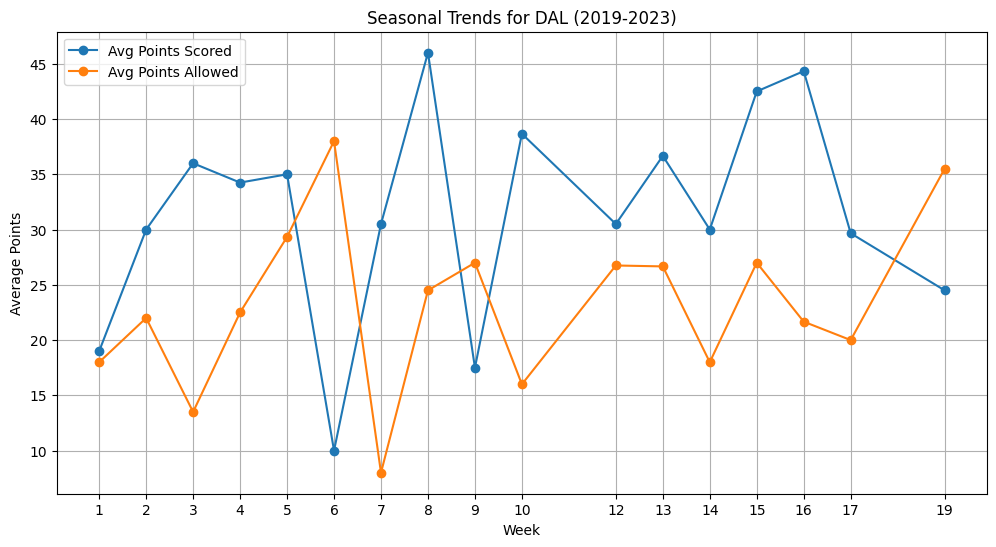

In [26]:
# Analyzing Seasonal Trends

import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('Games.csv')

# Filter for recent seasons if needed (e.g., 2019-2023)
df_recent = df[df['season'].isin([2019, 2020, 2021, 2022, 2023])]

# Group by team and week to calculate average points scored and allowed per week
team_weekly_performance = df_recent.groupby(['home_team', 'week']).agg(
    avg_points_scored=('home_score', 'mean'),
    avg_points_allowed=('away_score', 'mean')
).reset_index()

# Plotting seasonal trends for a selected team (e.g., DAL)
team = 'DAL'  # Example team
team_data = team_weekly_performance[team_weekly_performance['home_team'] == team]

plt.figure(figsize=(12, 6))
plt.plot(team_data['week'], team_data['avg_points_scored'], label='Avg Points Scored', marker='o')
plt.plot(team_data['week'], team_data['avg_points_allowed'], label='Avg Points Allowed', marker='o')
plt.title(f'Seasonal Trends for {team} (2019-2023)')
plt.xlabel('Week')
plt.ylabel('Average Points')
plt.xticks(team_data['week'])
plt.grid(True)
plt.legend()
plt.show()


In [30]:
# Analyzing Head-to-Head Matchups

df = pd.read_csv('Games.csv')

# Filter for recent seasons if needed (e.g., 2019-2023)
df_recent = df[df['season'].isin([2019, 2020, 2021, 2022, 2023])].copy()

# Calculate the game margin (home score minus away score)
df_recent['game_margin'] = df_recent['home_score'] - df_recent['away_score']

# Aggregate data by head-to-head matchups
head_to_head = df_recent.groupby(['home_team', 'away_team']).agg(
    games_played=('game_id', 'count'),
    avg_home_margin=('game_margin', 'mean'),
    home_wins=('home_team', lambda x: (df_recent.loc[x.index, 'home_score'] > df_recent.loc[x.index, 'away_score']).sum())
).reset_index()

# Calculate home win percentage
head_to_head['home_win_percentage'] = head_to_head['home_wins'] / head_to_head['games_played'] * 100

# Display the head-to-head summary
print("="*50)
print("Head-to-Head Matchup Summary:")
print(head_to_head.sort_values(by='home_win_percentage', ascending=False))
print("="*50)

Head-to-Head Matchup Summary:
    home_team away_team  games_played  avg_home_margin  home_wins  \
0         ARI       ATL             2              1.5          2   
430       LAR       LVR             1              1.0          1   
428       LAR       DET             1              9.0          1   
427       LAR       DEN             1             37.0          1   
425       LAR       CLE             1             17.0          1   
..        ...       ...           ...              ...        ...   
154       CIN        GB             1             -3.0          0   
602       NYJ        KC             1             -3.0          0   
603       NYJ       LAC             1            -21.0          0   
155       CIN       HOU             1             -3.0          0   
784       WAS       TEN             1             -4.0          0   

     home_win_percentage  
0                  100.0  
430                100.0  
428                100.0  
427                100.0  
425   

---

4. Advanced Metrics:
- Elo Ratings: Implement Elo ratings to rank teams and predict outcomes more accurately. Elo can also be used to simulate the rest of the season and predict playoff probabilities.
- Expected Points Added (EPA): Calculate or use existing metrics like EPA to evaluate player and team efficiency. Compare these metrics against the betting lines to identify value opportunities.

6. Value Betting Opportunities:
- Line Movements: Track how betting lines move leading up to a game. Significant movements can indicate where the smart money is going, and comparing these movements with your analysis can uncover value bets.
- Underdog Performance: Identify situations where underdogs consistently outperform expectations, either outright or against the spread.

---

# Old Working

In [ ]:
# --- Creating home_spread and away_spread columns in nfl.db --- #

# Function to calculate home_spread and away_spread
def calculate_spreads(spread_line):
    if spread_line > 0:
        # Home team is favored
        home_spread = f"+{spread_line}"
        away_spread = f"-{spread_line}"
    else:
        # Away team is favored
        home_spread = f"{spread_line}"
        away_spread = f"+{-spread_line}"
    return home_spread, away_spread

db_path = 'nfl.db'  # Update the path if needed
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Update each row in the 'Games' table with home_spread and away_spread
cursor.execute("SELECT game_id, spread_line FROM Games;")
games = cursor.fetchall()
for game in games:
    game_id, spread_line = game
    home_spread, away_spread = calculate_spreads(spread_line)
    update_query = "UPDATE Games SET home_spread = ?, away_spread = ? WHERE game_id = ?;"
    cursor.execute(update_query, (home_spread, away_spread, game_id))

# Commit the changes and close the connection
conn.commit()
conn.close()

print("Columns 'home_spread' and 'away_spread' have been added and updated for all rows in the 'Games' table.")


In [5]:
# --- Final Single Team --- #

# Function to determine the ATS result for a game using actual scores and spread
def ats_result(row, team):
    # Determine the spread based on whether the Cowboys are playing at home or away
    spread = float(row['home_spread']) if row['home_team'] == team else float(row['away_spread'])

    # Determine the actual score difference
    score_diff = row['home_score'] - row['away_score'] if row['home_team'] == team else row['away_score'] - row['home_score']

    # Compare score difference with the spread to determine ATS result
    if score_diff > spread:
        return 'Win'
    elif score_diff < spread:
        return 'Loss'
    else:
        return 'Push'

# Connect to the SQLite database
db_path = 'nfl.db'  # Adjust the path to your database file
conn = sqlite3.connect(db_path)

# Extracting relevant columns for Cowboys games in the 2023 season
relevant_columns = ['home_team', 'away_team', 'home_score', 'away_score', 'home_spread', 'away_spread']
cowboys_2023_games = pd.read_sql_query(
    "SELECT * FROM Games WHERE (home_team = 'NYG' OR away_team = 'NYG') AND season = 2023", 
    conn
)[relevant_columns]

# Apply the function to calculate ATS results
cowboys_2023_games['ATS_Result'] = cowboys_2023_games.apply(lambda row: ats_result(row, 'NYG'), axis=1)

# Calculate overall, home, and away ATS records
overall_ats_record = cowboys_2023_games['ATS_Result'].value_counts()
home_ats_record = cowboys_2023_games[cowboys_2023_games['home_team'] == 'NYG']['ATS_Result'].value_counts()
away_ats_record = cowboys_2023_games[cowboys_2023_games['away_team'] == 'NYG']['ATS_Result'].value_counts()

# Display the results
print("NYGlas Cowboys ATS Record for 2023 Season:")
print("Overall:", overall_ats_record)
print("Home:", home_ats_record)
print("Away:", away_ats_record)

# Close the database connection
conn.close()


NYGlas Cowboys ATS Record for 2023 Season:
Overall: ATS_Result
Loss    8
Win     6
Push    1
Name: count, dtype: int64
Home: ATS_Result
Win     3
Loss    2
Push    1
Name: count, dtype: int64
Away: ATS_Result
Loss    6
Win     3
Name: count, dtype: int64


In [8]:
# --- Final Loop --- #

# Function to determine the ATS result for a game using actual scores and spread
def ats_result(row, team):
    spread = float(row['home_spread']) if row['home_team'] == team else float(row['away_spread'])
    score_diff = row['home_score'] - row['away_score'] if row['home_team'] == team else row['away_score'] - row['home_score']
    if score_diff > spread:
        return 'Win'
    elif score_diff < spread:
        return 'Loss'
    else:
        return 'Push'

# Connect to the SQLite database
db_path = 'nfl.db'  # Adjust the path to your database file
conn = sqlite3.connect(db_path)

# List of all NFL teams
teams = ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 
         'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 
         'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

# Loop through each team to calculate ATS records
for team in teams:
    relevant_columns = ['home_team', 'away_team', 'home_score', 'away_score', 'home_spread', 'away_spread']
    team_games = pd.read_sql_query(
        f"SELECT * FROM Games WHERE (home_team = '{team}' OR away_team = '{team}') AND season = 2023", 
        conn
    )[relevant_columns]

    team_games['ATS_Result'] = team_games.apply(lambda row: ats_result(row, team), axis=1)

    overall_ats_record = team_games['ATS_Result'].value_counts()
    home_ats_record = team_games[team_games['home_team'] == team]['ATS_Result'].value_counts()
    away_ats_record = team_games[team_games['away_team'] == team]['ATS_Result'].value_counts()

    # Display the results for each team
    print(f"{team} ATS Record for 2023 Season:")
    print("Overall:", overall_ats_record)
    print("Home:", home_ats_record)
    print("Away:", away_ats_record)
    print("\n")  # Add a newline for better readability

# Close the database connection
conn.close()


ARI ATS Record for 2023 Season:
Overall: ATS_Result
Loss    8
Win     7
Name: count, dtype: int64
Home: ATS_Result
Win     4
Loss    3
Name: count, dtype: int64
Away: ATS_Result
Loss    5
Win     3
Name: count, dtype: int64


ATL ATS Record for 2023 Season:
Overall: ATS_Result
Loss    10
Win      5
Name: count, dtype: int64
Home: ATS_Result
Loss    5
Win     3
Name: count, dtype: int64
Away: ATS_Result
Loss    5
Win     2
Name: count, dtype: int64


BAL ATS Record for 2023 Season:
Overall: ATS_Result
Win     10
Loss     5
Name: count, dtype: int64
Home: ATS_Result
Win     4
Loss    3
Name: count, dtype: int64
Away: ATS_Result
Win     6
Loss    2
Name: count, dtype: int64


BUF ATS Record for 2023 Season:
Overall: ATS_Result
Loss    9
Win     6
Name: count, dtype: int64
Home: ATS_Result
Win     4
Loss    4
Name: count, dtype: int64
Away: ATS_Result
Loss    5
Win     2
Name: count, dtype: int64


CAR ATS Record for 2023 Season:
Overall: ATS_Result
Loss    9
Win     4
Push    2
Name: coun

In [5]:
### Old Working Single team ATS and O/U record this season

# Connect to the SQLite database
db_path = '../Database/nfl.db'  # Replace with your database path
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Define the team abbreviation
team = 'PHI'  # Replace with your team's abbreviation

# Query to get games for the specified team in the 2023 season
query = f"""
SELECT * FROM Games 
WHERE season = 2023 AND (away_team = '{team}' OR home_team = '{team}');
"""
cursor.execute(query)
games = cursor.fetchall()

beat_spread_count = 0
over_total_count = 0

for game in games:
    _, _, _, _, _, _, _, away_team, away_score, home_team, home_score, _, spread_line, total_line, _, _, _, _, _ = game
    team_score = home_score if team == home_team else away_score
    opponent_score = away_score if team == home_team else home_score
    adjusted_spread = -spread_line if team == away_team else spread_line
    beat_spread = team_score - opponent_score > adjusted_spread
    over_total = team_score + opponent_score > total_line
    if beat_spread:
        beat_spread_count += 1
    if over_total:
        over_total_count += 1

# Output results
print(f"Games Played: {len(games)}")
print(f"Beat the Spread: {beat_spread_count}")
print(f"Went Over Total: {over_total_count}")

# Close the database connection
conn.close()


Games Played: 15
Beat the Spread: 7
Went Over Total: 8
